In [284]:
import sys
sys.path.append("pyESN")
import numpy as np
from matplotlib import pyplot as plt
import pandas

from pyESN import ESN
import sklearn.metrics as sm
from scipy.special import expit, logit

from sklearn import preprocessing


from sklearn.grid_search import GridSearchCV
from sklearn.base import BaseEstimator, RegressorMixin

from sklearn.cross_validation import train_test_split

import pickle


%matplotlib inline

In [271]:
def getDataWindowed(data,inSize,outSize):
    if outSize > inSize:
        biggest = outSize
    else:
        biggest = inSize
    
    matrixIn = np.zeros((len(data)-biggest, inSize))
    matrixOut = np.zeros((len(data)-biggest, outSize))
    
    for i in range(len(data)-2*biggest):
        matrixIn[i,:] = data[i:i+inSize]
        matrixOut[i,:] = data[i+inSize+1:i+inSize+outSize+1]
    return matrixIn,matrixOut

In [327]:
def createFolds(dataSize, k):
    vector = np.arange(dataSize)
    splitted = np.array_split(vector,k+1)
    
    folds = []
    
    test_set = []
    for i in range(k):
        test_set = np.hstack((test_set, splitted[i]))
        val_set = splitted[i+1]
        folds.append((test_set.astype('int'),val_set.astype('int')))
    return folds

In [328]:
class skESN(BaseEstimator):
    def __init__(self, n_inputs=12,n_outputs=12,n_reservoir = 1000,
                 spectral_radius = 1.5, sparsity=0.3, teacher_forcing= True):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.n_reservoir = n_reservoir
        self.spectral_radius = spectral_radius
        self.sparsity = sparsity
        self.teacher_forcing = teacher_forcing

    def get_params(self,deep=True):
        return {'n_inputs': self.n_inputs, 'n_outputs': self.n_outputs, 'n_reservoir':self.n_reservoir,
               'spectral_radius':self.spectral_radius, 'teacher_forcing':self.teacher_forcing, 'sparsity':self.sparsity}
   
    def fit(self,X,y, inspect=False):
        self.esn = ESN(n_inputs = self.n_inputs,
          n_outputs = self.n_outputs,
          n_reservoir = self.n_reservoir,
          random_state=42,
          spectral_radius = self.spectral_radius,
          sparsity= self.sparsity,
          teacher_forcing= self.teacher_forcing,
          silent= True)
        self.esn.fit(X,y, inspect)
        return self

    def predict(self,X):
        return self.esn.predict(X, continuation=True)
    
    def score(self,X,y):
        y_pred = self.predict(X)
        score = sm.mean_squared_error(y_pred,y)
        return score

# Testing

In [329]:
b08 = pandas.read_csv('../data/b08c2.csv')
b08_viento = b08["viento"].as_matrix()

prediction_steps = 12
input_steps = 12

In [330]:
train_perc = 0.6

datalen = len(b08_viento)
trainlen = int(train_perc*(datalen))

minmax = preprocessing.MinMaxScaler(feature_range=(0,1)) 
standarization = preprocessing.StandardScaler()

minmax.fit(b08_viento[:trainlen].reshape(-1,1))
standarization.fit(b08_viento[:trainlen].reshape(-1,1))

preproc = minmax

data = preproc.transform(b08_viento.reshape(-1,1)).reshape((-1,)) if preproc else b08_viento

In [331]:
X,y = getDataWindowed(data,input_steps,prediction_steps)

In [332]:
train_data,train_output = X[:trainlen],y[:trainlen]
test_data, test_output  = X[trainlen:-prediction_steps],y[trainlen:-prediction_steps]

In [333]:
params = {'n_reservoir': [200],'spectral_radius':[0.5],
         'sparsity':[0.1]}

In [334]:
folds = createFolds(train_data.shape[0],5)
clf = skESN()
gs = GridSearchCV(clf, params, cv=folds, verbose=True, n_jobs=-1)
gs.fit(train_data,train_output)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished


GridSearchCV(cv=[(array([   0,    1, ..., 1165, 1166]), array([1167, 1168, ..., 2332, 2333])), (array([   0,    1, ..., 2332, 2333]), array([2334, 2335, ..., 3498, 3499])), (array([   0,    1, ..., 3498, 3499]), array([3500, 3501, ..., 4664, 4665])), (array([   0,    1, ..., 4664, 4665]), array([4666, 4667, ..., 5830, 5831])), (array([   0,    1, ..., 5830, 5831]), array([5832, 5833, ..., 6996, 6997]))],
       error_score='raise',
       estimator=skESN(n_inputs=12, n_outputs=12, n_reservoir=1000, sparsity=0.3,
   spectral_radius=1.5, teacher_forcing=True),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'sparsity': [0.1], 'spectral_radius': [0.5], 'n_reservoir': [200]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=True)

In [335]:
clf.set_params(**gs.best_params_)

skESN(n_inputs=12, n_outputs=12, n_reservoir=200, sparsity=0.1,
   spectral_radius=0.5, teacher_forcing=True)

In [336]:
clf.fit(train_data, train_output)

skESN(n_inputs=12, n_outputs=12, n_reservoir=200, sparsity=0.1,
   spectral_radius=0.5, teacher_forcing=True)

In [337]:
X_test = preproc.inverse_transform(test_data) if preproc else test_data
y_test = preproc.inverse_transform(test_output) if preproc else test_output
clf.score(X_test,y_test)

11.218537101972395

In [338]:
np.savez("best_params",**clf.get_params())
np.savez("train_data", X=train_data, y=train_output )
np.savez("test_data", X=test_data, y=test_output)

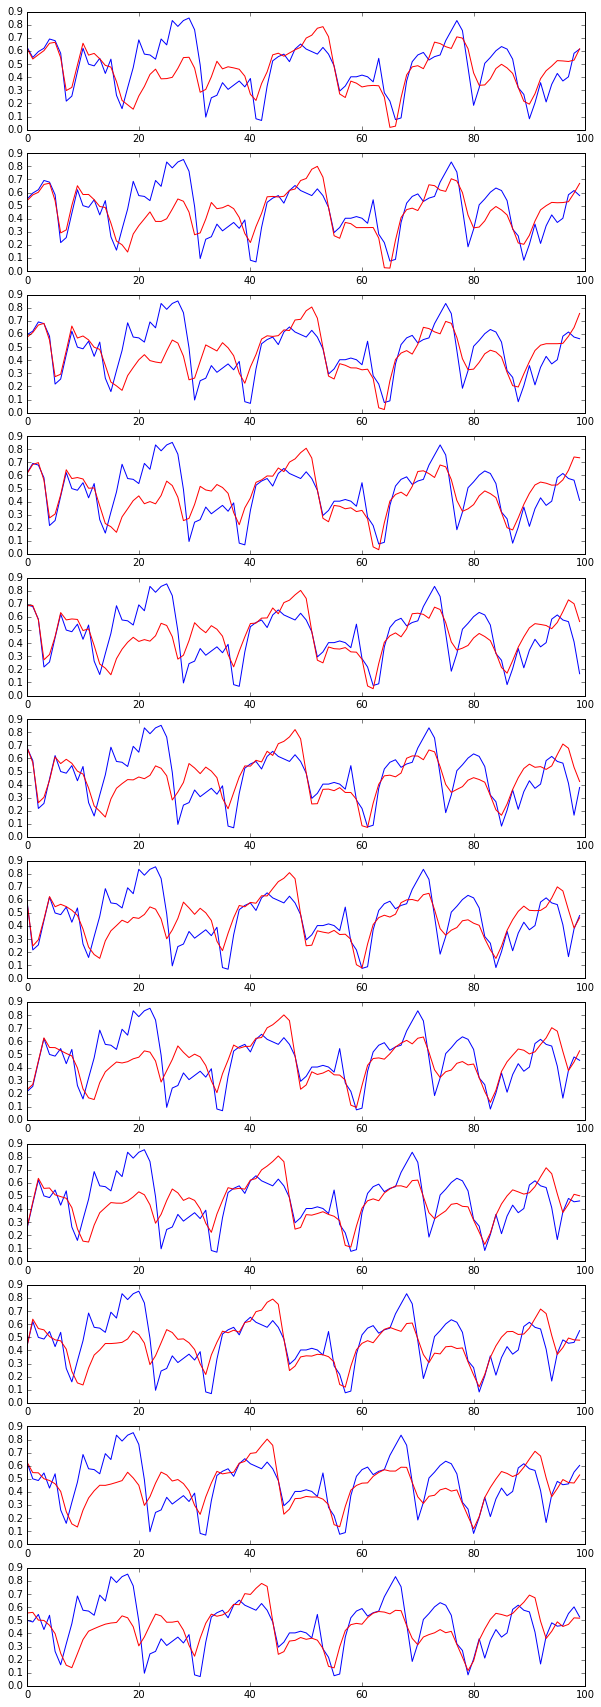

In [342]:
y_pred = clf.predict(test_data)

fig = plt.figure(figsize=(10,30))
for i in range(12):
    ax = fig.add_subplot(12,1,i+1)
    ax.plot(test_output[:100,i])
    ax.plot(y_pred[:100,i],'r')

In [340]:
np.hstack((np.arange(100,1000,200) , np.arange(1000,5000,1000)))

array([ 100,  300,  500,  700,  900, 1000, 2000, 3000, 4000])

In [341]:
np.linspace(0,0.9,10)

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9])